# Vegetable Classification
[Original Kaggle Notebook](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)

* Classify 15 different types of vegetables using transfer learning. 

# Import data and helper documents

In [1]:
import tensorflow as tf
import os 


In [2]:
list_dir = os.listdir('.')

if 'vegetable-images.zip?dl=0' not in list_dir:
  # fetch images
  !wget https://www.dropbox.com/s/lbqzfovdqs02nr8/vegetable-images.zip?dl=0
  # fetch helper documents
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [3]:
# Let's create a function tgo compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History Objects
  """

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  
  total_val_acc = val_acc + new_history.history['val_accuracy'] 
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Trainig Acc')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  # Make plot for loss
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Trainig Loss')
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and validation loss')



  

  

In [4]:
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir

In [5]:

dir_list = os.listdir('.')

# unzip data if docs don't exist yet
if 'train_30' not in dir_list:
  unzip_data('vegetable-images.zip?dl=0')

In [6]:
# Check some of the directories
walk_through_dir('validation')

There are 15 directories and 0 images in 'validation'.
There are 0 directories and 200 images in 'validation/Capsicum'.
There are 0 directories and 200 images in 'validation/Radish'.
There are 0 directories and 200 images in 'validation/Pumpkin'.
There are 0 directories and 200 images in 'validation/Cauliflower'.
There are 0 directories and 200 images in 'validation/Potato'.
There are 0 directories and 200 images in 'validation/Bean'.
There are 0 directories and 200 images in 'validation/Cucumber'.
There are 0 directories and 200 images in 'validation/Brinjal'.
There are 0 directories and 200 images in 'validation/Cabbage'.
There are 0 directories and 200 images in 'validation/Broccoli'.
There are 0 directories and 200 images in 'validation/Bitter_Gourd'.
There are 0 directories and 200 images in 'validation/Papaya'.
There are 0 directories and 200 images in 'validation/Bottle_Gourd'.
There are 0 directories and 200 images in 'validation/Tomato'.
There are 0 directories and 200 images 

# Preprocess data

Lets setup our images and create functions to create new models with the same architecture


## Create image datasets from directories

In [7]:


train_30_percent = tf.keras.preprocessing.image_dataset_from_directory(
  'train_30',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  'train',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  'test',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  'validation',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

Found 4500 files belonging to 15 classes.


2022-06-12 14:23:25.936356: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Create data augmentation layer

In [8]:
data_augmentation_dial = 0.2
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomZoom(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomHeight(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomWidth(data_augmentation_dial),
  # tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
  # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
], name='data_augmentation_layer')

## Create function to visualize images (normal/augmented)

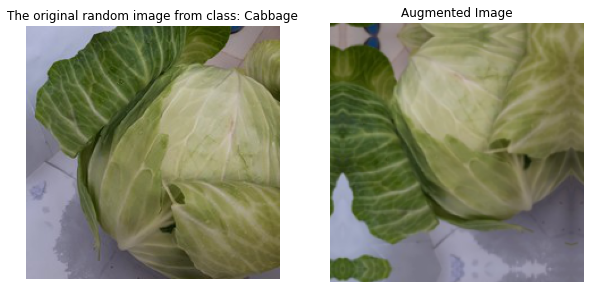

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Set random states
# random.seed(42)
# tf.random.set_seed(42)

def view_random_image():
  target_class = random.choice(train_data.class_names)
  target_dir = 'train/' + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + '/' + random_image

  plt.figure(figsize=(10,15))

  # Read in random image
  image = mpimg.imread(random_image_path)
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title(f'The original random image from class: {target_class}')
  plt.axis(False)


  # Now plot the augmented random image
  augmented_image = data_augmentation(tf.expand_dims(image, axis=0), training=True)
  plt.subplot(1, 2, 2)
  plt.imshow(tf.squeeze(augmented_image/255.))
  plt.title(f'Augmented Image')
  plt.axis(False)

view_random_image()

## Creating checkpoint callback


In [10]:
checkpoint_path = 'vegetables_checkpoint_30_percent/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

# Create Feature Extraction models



## Feature Extraction base model

In [11]:
from numpy import e
from tensorflow.keras import layers


# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

# Extract features from model
x = layers.GlobalAveragePooling2D (name='global_average_pooling_layer')(x)

outputs = layers.Dense(15, activation='softmax', name='output_layer')(x)




16719872/16705208 [==============================] - 0s 0us/step


## Model 1: Feature Extraction

In [ ]:

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])



initial_epochs = 5
history_1 = model_1.fit(
    train_30_percent, 
    epochs = initial_epochs,
    steps_per_epoch=len(train_30_percent),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[checkpoint_callback]
)
plot_loss_curves(history_1)

Epoch 1/5


2022-06-12 14:23:35.392921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


141/141 [==============================] - 195s 1s/step - loss: 0.6999 - accuracy: 0.8720 - val_loss: 0.1729 - val_accuracy: 0.9767

Epoch 00001: val_loss improved from inf to 0.17295, saving model to vegetables_checkpoint_30_percent/checkpoint.ckpt


2022-06-12 14:26:55.477491: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: vegetables_checkpoint_30_percent/checkpoint.ckpt/assets


/Users/kamangir/opt/miniconda3/envs/bolt2/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
141/141 [==============================] - 181s 1s/step - loss: 0.1430 - accuracy: 0.9796 - val_loss: 0.0895 - val_accuracy: 0.9877

Epoch 00002: val_loss improved from 0.17295 to 0.08951, saving model to vegetables_checkpoint_30_percent/checkpoint.ckpt


In [ ]:
model_1_results = model_1.evaluate(test_data)

* model_1 gives great results with 99% accuracy on the full test dataset
* model_1 only uses 30% of training data, we'll use the full training set once we fine tune the model

Since model_1 has good performance we'll checkpoint it to create the fine tuned models to squeeze a little more out of our model

## Model 2: Fine tuning


In [ ]:
# Load in the model
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)


### Unfreeze layers

In [ ]:
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)



In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

## Fit the model

In [ ]:

fine_tuned_epochs = initial_epochs + 5

history_2 = model_2.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_2)

In [ ]:
model_2_results = model_2.evaluate(test_data)

In [ ]:
model_1_results, model_2_results

* unfreezing some layers gave us a higher percentage although it's already high from model_1

lets try one more time and we'll unfreeze more layers (30)

## Model 3: Unfreeze more layers

In [ ]:
model_3 = tf.keras.Model(inputs, outputs)
model_3.load_weights(checkpoint_path)

In [ ]:
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_3.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)


### Fit the model


In [ ]:
fine_tuned_epochs = initial_epochs + 5

history_3 = model_3.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_3)

In [ ]:
model_3_results = model_3.evaluate(test_data)

# Compare Models

In [ ]:
import pandas as pd
results = [model_1_results , model_2_results, model_3_results]
results_pd = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_pd

# Summary

from the start `EfficientNetB0` habe us a very high score with only 30% of the traning data_augmentation

`model_3` gives us the best accuracy score with 30 layers of the base model unfrozen and re-fitted on our custom data

In [ ]:
model_3.summary()